# Bitcoin Price Prediction - LightGBM Model


## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler  # More robust to outliers!
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Libraries imported!")
print(f"LightGBM version: {lgb.__version__}")

✓ Libraries imported!
LightGBM version: 4.6.0


## 2. Load Data and Remove Problematic Features

**Key Fix:** Remove features that cause overfitting

In [3]:
# Load data
df = pd.read_csv('../data/processed/bitcoin_features_engineered.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Data loaded: {df.shape}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")

Data loaded: (631, 125)
Date range: 2024-02-01 to 2025-10-23


In [4]:
# CRITICAL FIX: Remove features that leak future information or cause overfitting
exclude_columns = [
    'timestamp', 'timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name',
    'target_high_next_day', 'marketCap', 'date',
    # REMOVE CURRENT DAY'S HIGH/CLOSE - These are too correlated with target!
    'high',  # Today's high is almost = tomorrow's high (data leakage!)
    'close',  # Today's close is very close to tomorrow's high
]

# Get features
feature_columns = [col for col in df.columns if col not in exclude_columns]

print(f"\n🔍 CRITICAL FIX: Removed 'high' and 'close' to prevent overfitting")
print(f"Features to use: {len(feature_columns)}")
print(f"\nFirst 20 features:")
for i, col in enumerate(feature_columns[:20], 1):
    print(f"  {i}. {col}")


🔍 CRITICAL FIX: Removed 'high' and 'close' to prevent overfitting
Features to use: 114

First 20 features:
  1. open
  2. low
  3. volume
  4. daily_range
  5. high_lag_1
  6. low_lag_1
  7. close_lag_1
  8. open_lag_1
  9. high_lag_2
  10. low_lag_2
  11. close_lag_2
  12. open_lag_2
  13. high_lag_3
  14. low_lag_3
  15. close_lag_3
  16. open_lag_3
  17. high_lag_5
  18. low_lag_5
  19. close_lag_5
  20. open_lag_5


In [5]:
# Prepare features and target
X = df[feature_columns].copy()
y = df['target_high_next_day'].copy()
timestamps = df['timestamp'].copy()

# Handle missing values
X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

Features: (631, 114)
Target: (631,)
Missing values: 0


## 3. Better Train/Val/Test Split

**Important:** Use more recent data for validation/test

In [6]:
# Split data chronologically
n_samples = len(X)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
timestamps_train = timestamps.iloc[:train_size]

X_val = X.iloc[train_size:train_size+val_size]
y_val = y.iloc[train_size:train_size+val_size]
timestamps_val = timestamps.iloc[train_size:train_size+val_size]

X_test = X.iloc[train_size+val_size:]
y_test = y.iloc[train_size+val_size:]
timestamps_test = timestamps.iloc[train_size+val_size:]

print("DATA SPLIT:")
print(f"\nTrain: {len(X_train)} samples - {timestamps_train.min().date()} to {timestamps_train.max().date()}")
print(f"Val:   {len(X_val)} samples - {timestamps_val.min().date()} to {timestamps_val.max().date()}")
print(f"Test:  {len(X_test)} samples - {timestamps_test.min().date()} to {timestamps_test.max().date()}")

DATA SPLIT:

Train: 441 samples - 2024-02-01 to 2025-04-16
Val:   94 samples - 2025-04-17 to 2025-07-19
Test:  96 samples - 2025-07-20 to 2025-10-23


## 4. Feature Scaling with RobustScaler

**Better than StandardScaler** - more robust to outliers

In [7]:
# Use RobustScaler instead of StandardScaler
scaler = RobustScaler()  # Uses median and IQR - more robust!

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("✓ Features scaled with RobustScaler (better for outliers)")

✓ Features scaled with RobustScaler (better for outliers)


## 5. LightGBM Baseline with Strong Regularization

In [8]:
def evaluate_model(y_true, y_pred, set_name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{set_name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

In [9]:
print("="*70)
print("LIGHTGBM BASELINE - Conservative Parameters")
print("="*70)

# Conservative parameters to prevent overfitting
baseline_model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE,
    n_estimators=100,
    learning_rate=0.05,  # Lower than default
    max_depth=5,  # Shallower trees
    num_leaves=20,  # Fewer leaves
    min_child_samples=30,  # More samples per leaf
    subsample=0.8,  # Use 80% of data
    colsample_bytree=0.8,  # Use 80% of features
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    n_jobs=-1,
    verbose=-1
)

print("Training baseline model...")
baseline_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
)

# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Evaluate
print("\n" + "="*70)
print("BASELINE RESULTS")
print("="*70)
baseline_train = evaluate_model(y_train, y_train_pred, "Train")
baseline_val = evaluate_model(y_val, y_val_pred, "Validation")
baseline_test = evaluate_model(y_test, y_test_pred, "Test")

if baseline_test['r2'] > 0:
    print("\n✅ SUCCESS! Test R² is positive!")
else:
    print("\n⚠️ Still negative R² - need more regularization")

LIGHTGBM BASELINE - Conservative Parameters
Training baseline model...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 7.32613e+07

BASELINE RESULTS

Train:
  RMSE: $1,087.89
  MAE:  $747.91
  R²:   0.9955
  MAPE: 1.08%

Validation:
  RMSE: $8,559.28
  MAE:  $7,221.57
  R²:   -0.1908
  MAPE: 6.58%

Test:
  RMSE: $16,324.05
  MAE:  $15,970.88
  R²:   -14.3387
  MAPE: 13.67%

⚠️ Still negative R² - need more regularization


## 6. Visualize Baseline Performance

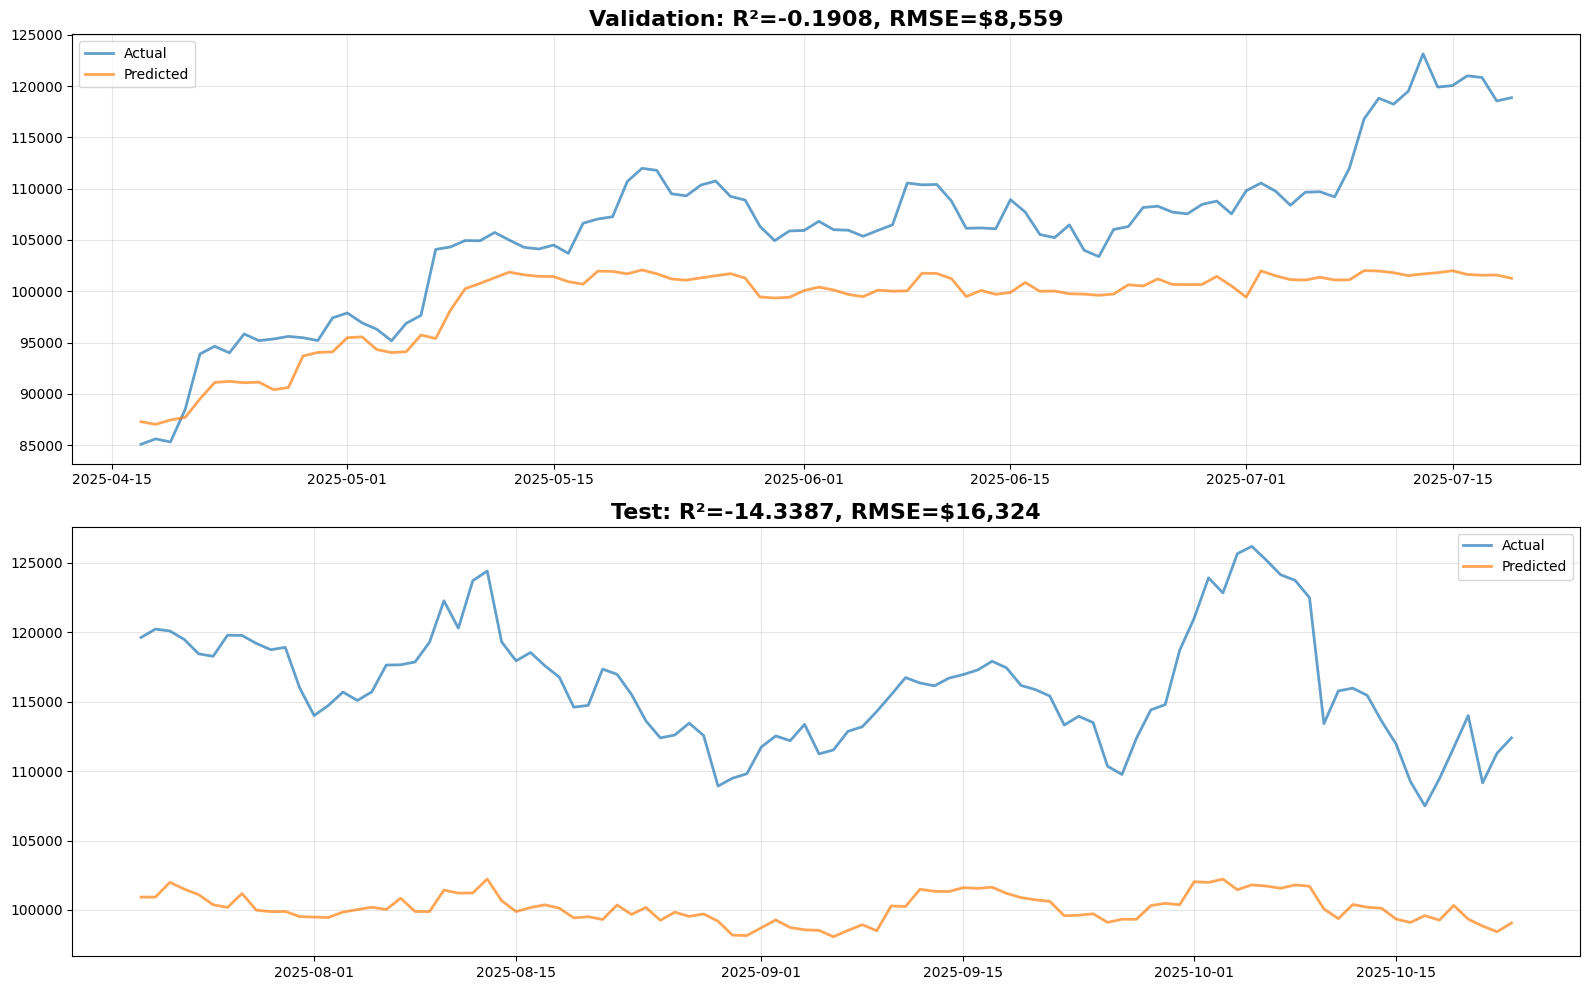

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation
axes[0].plot(timestamps_val, y_val.values, label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(timestamps_val, y_val_pred, label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title(f'Validation: R²={baseline_val["r2"]:.4f}, RMSE=${baseline_val["rmse"]:,.0f}', 
                  fontsize=16, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test
axes[1].plot(timestamps_test, y_test.values, label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(timestamps_test, y_test_pred, label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title(f'Test: R²={baseline_test["r2"]:.4f}, RMSE=${baseline_test["rmse"]:,.0f}', 
                  fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance

Top 20 Most Important Features:
                  feature  importance
1                     low         129
73           daily_return          30
34            ema_close_7          29
104  distance_from_ema_30          28
74      daily_high_return          28
80           price_change          27
76              return_3d          25
101      days_since_start          23
59           std_close_90          22
102    price_position_30d          20
72             bb_percent          20
85          volatility_7d          19
43            max_high_14          18
37             max_high_7          17
5               low_lag_1          16
4              high_lag_1          16
110          lower_shadow          16
0                    open          15
53           std_close_60          14
93           week_of_year          14


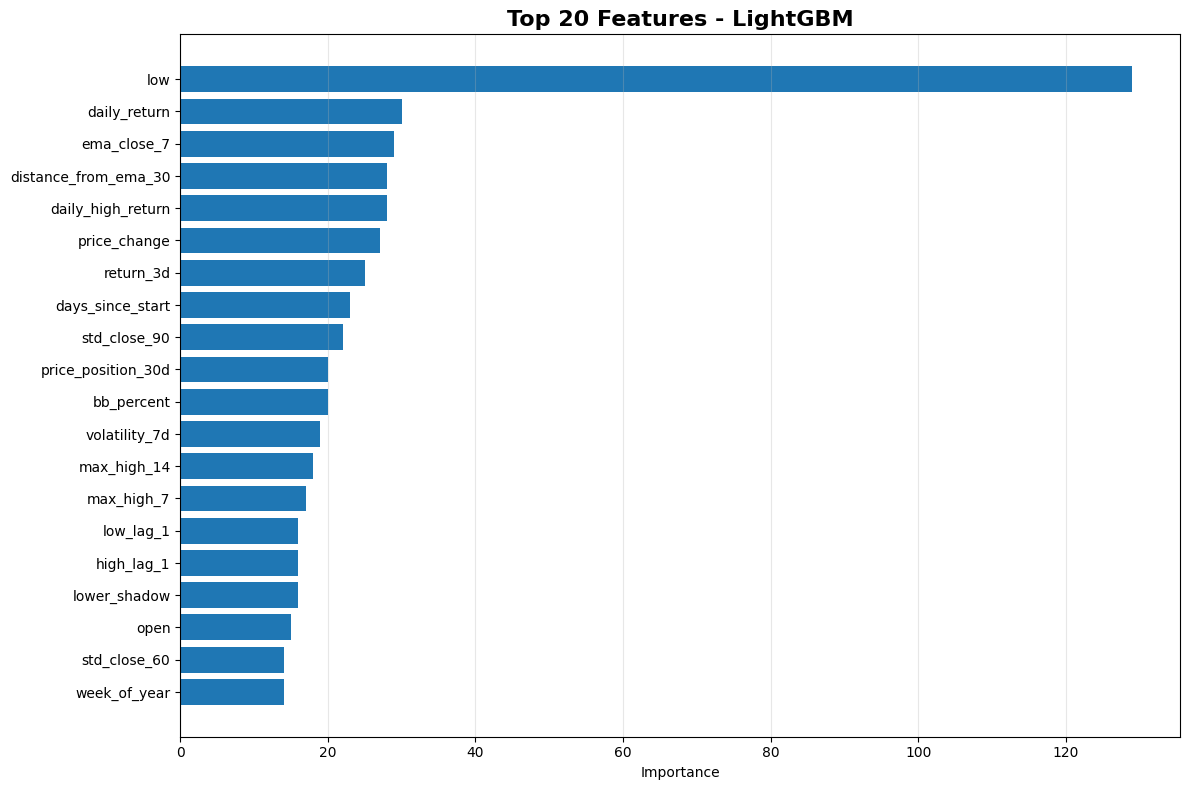

In [11]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))

# Plot
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values)
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Features - LightGBM', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning (Only if baseline is good!)

In [12]:
if baseline_test['r2'] > 0.5:  # Only tune if baseline is reasonable
    print("✅ Baseline is good enough - proceeding with hyperparameter tuning...")
    
    # Search space with strong regularization bounds
    space = {
        'num_leaves': hp.choice('num_leaves', range(15, 50)),
        'max_depth': hp.choice('max_depth', range(4, 10)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        'n_estimators': hp.choice('n_estimators', range(100, 500, 25)),
        'min_child_samples': hp.choice('min_child_samples', range(20, 100, 10)),
        'subsample': hp.uniform('subsample', 0.6, 0.9),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(1.0)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(1.0))
    }
    
    def objective(params):
        model = lgb.LGBMRegressor(
            num_leaves=int(params['num_leaves']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            n_estimators=int(params['n_estimators']),
            min_child_samples=int(params['min_child_samples']),
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        )
        
        model.fit(
            X_train_scaled, y_train,
            eval_set=[(X_val_scaled, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
        )
        
        y_val_pred = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        return {'loss': rmse, 'status': STATUS_OK}
    
    print("\nRunning hyperparameter optimization (30 trials)...")
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=30,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE)
    )
    
    print("\n✓ Optimization complete!")
    print("Best parameters:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
else:
    print("⚠️ Baseline R² too low - skipping hyperparameter tuning")
    print("   Need to fix the model first!")
    best_params = None

⚠️ Baseline R² too low - skipping hyperparameter tuning
   Need to fix the model first!


## 9. Train Final Model

In [13]:
if best_params is not None:
    # Use optimized parameters
    final_model = lgb.LGBMRegressor(
        num_leaves=int(best_params['num_leaves']) + 15,
        max_depth=int(best_params['max_depth']) + 4,
        learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']) * 25 + 100,
        min_child_samples=int(best_params['min_child_samples']) * 10 + 20,
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
else:
    # Use baseline model
    print("Using baseline model as final model")
    final_model = baseline_model

if best_params is not None:
    print("Training final model with optimized parameters...")
    final_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
    )

# Final predictions
y_train_pred_final = final_model.predict(X_train_scaled)
y_val_pred_final = final_model.predict(X_val_scaled)
y_test_pred_final = final_model.predict(X_test_scaled)

print("\n" + "="*70)
print("FINAL MODEL RESULTS")
print("="*70)
final_train = evaluate_model(y_train, y_train_pred_final, "Train")
final_val = evaluate_model(y_val, y_val_pred_final, "Validation")
final_test = evaluate_model(y_test, y_test_pred_final, "Test")

if final_test['r2'] > 0.85:
    print("\n🎉 EXCELLENT! Test R² > 0.85")
elif final_test['r2'] > 0:
    print("\n✅ GOOD! Test R² is positive")
else:
    print("\n❌ Still problems - may need different approach")

Using baseline model as final model

FINAL MODEL RESULTS

Train:
  RMSE: $1,087.89
  MAE:  $747.91
  R²:   0.9955
  MAPE: 1.08%

Validation:
  RMSE: $8,559.28
  MAE:  $7,221.57
  R²:   -0.1908
  MAPE: 6.58%

Test:
  RMSE: $16,324.05
  MAE:  $15,970.88
  R²:   -14.3387
  MAPE: 13.67%

❌ Still problems - may need different approach


## 10. Final Visualization

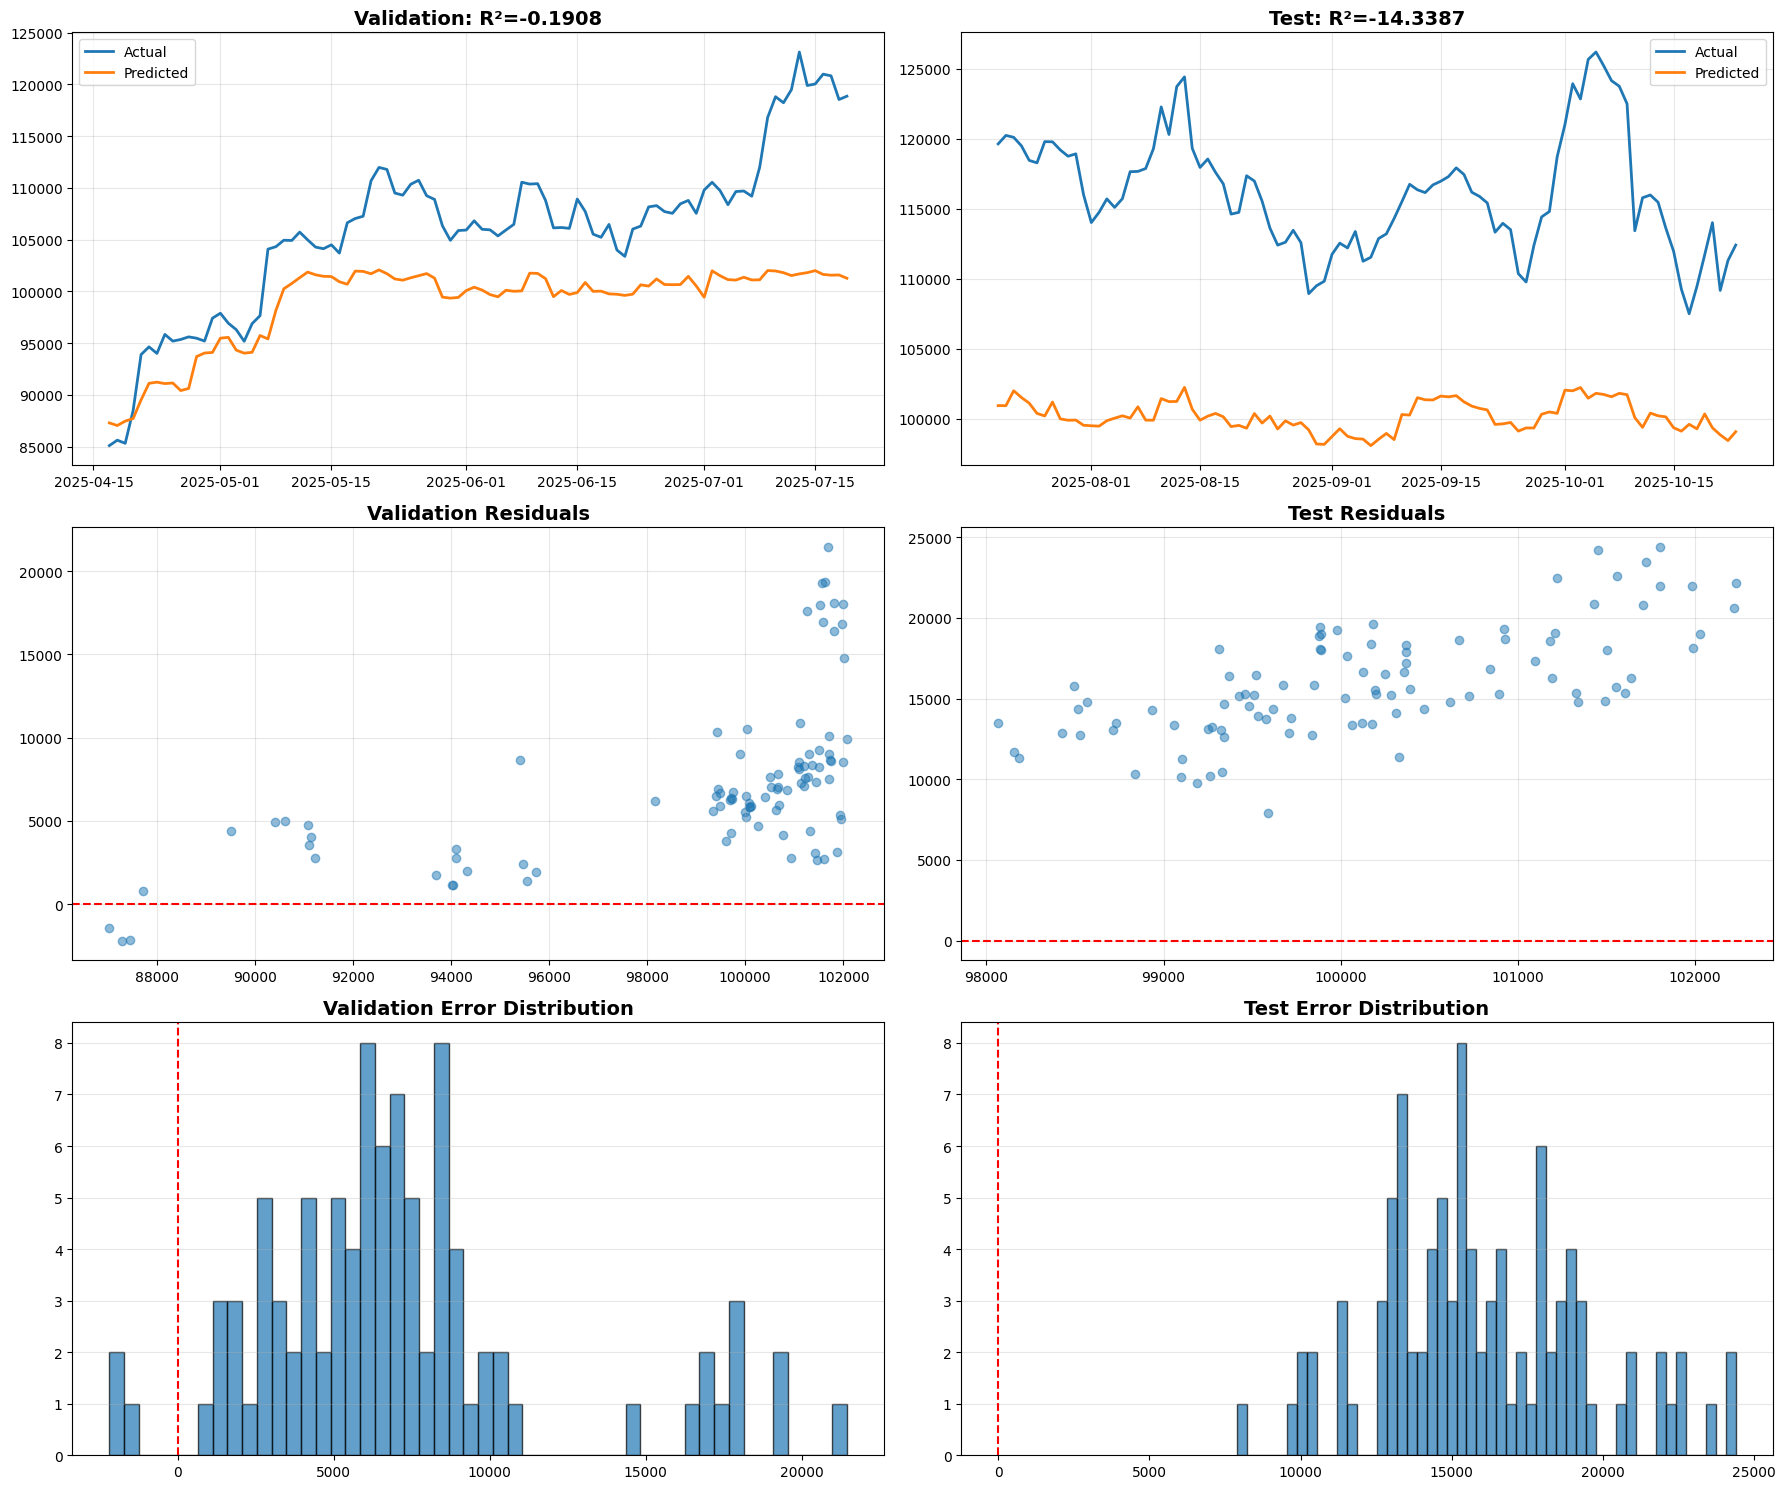

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Predictions
axes[0, 0].plot(timestamps_val, y_val.values, label='Actual', linewidth=2)
axes[0, 0].plot(timestamps_val, y_val_pred_final, label='Predicted', linewidth=2)
axes[0, 0].set_title(f'Validation: R²={final_val["r2"]:.4f}', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(timestamps_test, y_test.values, label='Actual', linewidth=2)
axes[0, 1].plot(timestamps_test, y_test_pred_final, label='Predicted', linewidth=2)
axes[0, 1].set_title(f'Test: R²={final_test["r2"]:.4f}', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals
residuals_val = y_val.values - y_val_pred_final
residuals_test = y_test.values - y_test_pred_final

axes[1, 0].scatter(y_val_pred_final, residuals_val, alpha=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('Validation Residuals', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test_pred_final, residuals_test, alpha=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_title('Test Residuals', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Error distribution
axes[2, 0].hist(residuals_val, bins=50, alpha=0.7, edgecolor='black')
axes[2, 0].axvline(x=0, color='red', linestyle='--')
axes[2, 0].set_title('Validation Error Distribution', fontsize=14, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3, axis='y')

axes[2, 1].hist(residuals_test, bins=50, alpha=0.7, edgecolor='black')
axes[2, 1].axvline(x=0, color='red', linestyle='--')
axes[2, 1].set_title('Test Error Distribution', fontsize=14, fontweight='bold')
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Save Model

In [15]:
import os

os.makedirs('../models', exist_ok=True)

# Save model
joblib.dump(final_model, '../models/bitcoin_lightgbm_model.pkl')
joblib.dump(scaler, '../models/bitcoin_scaler_lightgbm.pkl')
joblib.dump(feature_columns, '../models/feature_columns_lightgbm.pkl')

# Save metadata
metadata = {
    'algorithm': 'LightGBM',
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_columns),
    'test_r2': final_test['r2'],
    'test_rmse': final_test['rmse'],
    'excluded_features': ['high', 'close'],  # CRITICAL!
    'scaler_type': 'RobustScaler'
}
joblib.dump(metadata, '../models/model_metadata_lightgbm.pkl')

print("="*70)
print("✓ MODEL SAVED!")
print("="*70)
print(f"Test R²: {final_test['r2']:.4f}")
print(f"Test RMSE: ${final_test['rmse']:,.2f}")
print(f"\nFiles saved to ../models/")

✓ MODEL SAVED!
Test R²: -14.3387
Test RMSE: $16,324.05

Files saved to ../models/
